In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.distributions.categorical import Categorical

import random
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from itertools import batched

from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from board3 import Board3
from controller3 import ActionController

import copy

random.seed(0)
torch.manual_seed(0)

In [2]:
def binary(x, bits):
    mask = 2**torch.arange(bits)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).byte()

In [3]:
def to_emb(b: Board3):

    py, px = b.get_player_position()
    ey, ex = b.get_enemy_position()
    ty, tx = b.get_todd_position()

    mws = [0 for _ in range(16)]

    for my, mx in b.mw:
        mws[my * 4 + mx] = 1

    mwe = torch.Tensor(mws)

    pe = torch.cat([nn.functional.one_hot(torch.LongTensor([x]), num_classes=4) for x in [py, px, ey, ex, ty, tx]], dim=0)

    return torch.cat([pe.flatten().float(), mwe], dim=0).unsqueeze(0)


def pos_encode(max_len, d_model):
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

  0%|          | 0/50 [00:00<?, ?it/s]

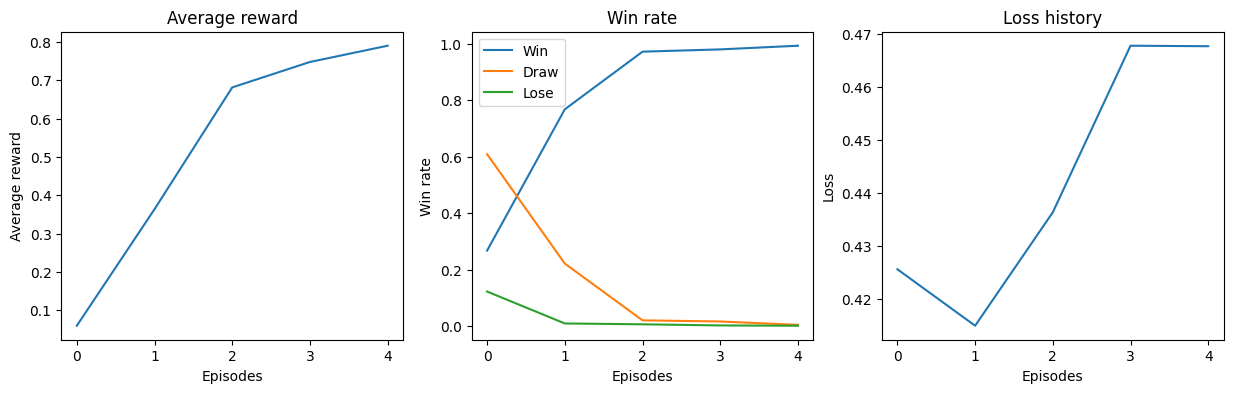

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, max_len=50):
        super(Net, self).__init__()

        self.el1 = nn.TransformerEncoderLayer(d_model=input_size, nhead=4, dim_feedforward=64, batch_first=True)
        self.el2 = nn.TransformerEncoderLayer(d_model=input_size, nhead=4, dim_feedforward=64, batch_first=True)

        self.en1 = nn.TransformerEncoder(self.el1, num_layers=1)
        self.en2 = nn.TransformerEncoder(self.el2, num_layers=1)

        self.pos = nn.Parameter(pos_encode(max_len, input_size), requires_grad=False)


        self.a = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LogSoftmax(dim=-1),
        )

        self.c = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        # ex = x + self.pos[:x.shape[1]]
        ex = x
        e1 = self.en1(ex)
        e2 = self.en2(ex)
        return self.a(e1), self.c(e2)


def to_embh(h, b):
    # eh = []
    # for x in h:
    #     eh.append(torch.cat([x[0], nn.functional.one_hot(x[1], num_classes=to_emb(Board3()).shape[-1])], dim=0))
    #
    # eh.append()
    # eh = torch.cat(eh, dim=0)
    return to_emb(b)

def episode(net, n=10, walk_time=1000, step=1600):
    env = Board3(walk_time=walk_time)
    h = []
    net.eval()

    for _ in range(n):

        s = to_embh(h, env)
        with torch.no_grad():
            l, c = net(s)

        m = Categorical(logits=l)
        action = m.sample()
        nv, reward, end = ActionController.step(env, action.item(), step)
        h.append((to_emb(env), action, l, reward))
        if end:
            break
        env = nv

    return h



def gen_episode_batch(net, n1=100, n2=10, walk_time=1000, step=1600):

    hs = [episode(net, n2, walk_time=walk_time, step=step) for _ in range(n1)]
    bds = []
    acs = []
    pls = []
    rws = []
    for h in hs:
        bds.extend([b[0] for b in h])
        acs.extend([b[1] for b in h])
        pls.extend([b[2] for b in h])
        accr = 0
        rs = []
        for b in reversed(h):
            accr = accr * 0.9 + b[3]
            rs.insert(0, accr)
        rws.extend(rs)

    tb = torch.cat(bds, dim=0)
    ta = torch.cat(acs, dim=0)
    tl = torch.cat(pls, dim=0)
    tr = torch.Tensor(rws)

    return tb, ta, tl, tr

def test(net, n1=100, n2=10, walk_time=1000, step=1600):
    net.eval()
    w, d, l = 0, 0, 0
    for _ in range(n1):
        h = episode(net, n2, walk_time=walk_time, step=step)
        if h[-1][-1] == 1:
            w += 1
        elif h[-1][-1] == -1:
            l += 1
        else:
            d += 1

    return w / n1, d / n1, l / n1


def train(net, td, epochs=10, lr=0.01):
    net.train()
    optimizer = optim.AdamW(net.parameters(), lr=lr, weight_decay=0.1)
    grad = []
    ls = []

    el = []
    for epoch in range(epochs):
        for b, a, l, r in DataLoader(TensorDataset(td[0], td[1], td[2], td[3]), batch_size=128, shuffle=True):
            if r.shape[0] < 2:
                continue

            optimizer.zero_grad()
            o, c = net(b)

            ratio = torch.exp(o - l)
            adv = r - c.squeeze()
            adv = (adv - adv.mean()) / (adv.std() + 1e-5)

            e = torch.gather(ratio, 1, a.unsqueeze(-1)).squeeze()
            be = e * adv.detach()
            ce = torch.clamp(e, min=0.8, max=1.2) * adv.detach()
            loss = torch.mean(-torch.min(be, ce)) + 0.5 * torch.mean(adv ** 2) - 0.01 * Categorical(logits=o).entropy().mean()
            try:
                loss.backward()
            except Exception as e:
                print("NaN detected", epoch)
                print(net.state_dict())
                print('------')
                print(min([torch.min(x) for x in grad]), max([torch.max(x) for x in grad]))
                print('------')
                print(ls[-1])
                print(e)
                raise Exception('hue')

            grad.append(net.a[0].weight.grad.clone().detach())
            ls.append(copy.deepcopy(net.state_dict()))

            el.append(loss.item())
            optimizer.step()

    return el


net = Net(to_emb(Board3()).shape[1], ActionController.get_action_space())

torch.autograd.set_detect_anomaly(True)

ar = []
tr = []
lh = []

samples = 500
turns = 20
walk_time = 1000
step = 1600
epochs = 5
lr = 0.001
test_samples = 100

for _ in tqdm(range(50)):
    td = gen_episode_batch(net, n1=samples, n2=turns, walk_time=walk_time, step=step)
    lt = train(net, td, epochs=epochs, lr=lr)
    lh.append(lt[-1])

    td = gen_episode_batch(net, n1=test_samples, n2=turns, walk_time=walk_time, step=step)

    ar.append(sum(td[-1]) / len(td[-1]))
    tr.append(test(net, n1=test_samples, n2=turns, walk_time=walk_time, step=step))


nar = ar.copy()
ntr = tr.copy()
nlh = lh.copy()

nw = [x[0] for x in ntr]
nd = [x[1] for x in ntr]
nl = [x[2] for x in ntr]

nar = [sum(nar[i:i+10]) / 10 for i in range(0, len(nar), 10)]
nw = [sum(nw[i:i+10]) / 10 for i in range(0, len(nw), 10)]
nd = [sum(nd[i:i+10]) / 10 for i in range(0, len(nd), 10)]
nl = [sum(nl[i:i+10]) / 10 for i in range(0, len(nl), 10)]
nlh = [sum(nlh[i:i+10]) / 10 for i in range(0, len(nlh), 10)]

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].plot(nar)
ax[0].set_title('Average reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Average reward')
ax[1].plot(nw)
ax[1].plot(nd)
ax[1].plot(nl)
ax[1].set_title('Win rate')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Win rate')
ax[1].legend(['Win', 'Draw', 'Lose'])
ax[2].plot(nlh)
ax[2].set_title('Loss history')
ax[2].set_xlabel('Episodes')
ax[2].set_ylabel('Loss')
plt.show()